# Configuration

Import here the libraries you will need

In [ ]:
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns

from fbprophet import Prophet
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, adfuller, kpss, pacf

Importing plotly failed. Interactive plots will not work.


Define the required functions

In [ ]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(10,3), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

In [ ]:
def test_stationarity(timeseries, N):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=N).mean()
    rolstd = timeseries.rolling(window=N).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [ ]:
def interpret_dftest(dftest, th):
    print('ADF Statistic: %f' % dftest[0])
    print('p-value: %f' % dftest[1])
    if dftest[1] <= th: print('We can reject the null hypothesis. Time series is stationary')
    else: print('Time series is not stationary')
    print('Critical Values:')
    for key, value in dftest[4].items():
        print('\t%s: %.3f' % (key, value))

In [ ]:
def interpret_kpsstest(kpsstest, th):
    print('KPSS Statistic: %f' % kpsstest[0])
    print('p-value: %f' % kpsstest[1])
    if kpsstest[1] > th: print('We can reject the null hypothesis. Time series is not stationary')
    else: print('Time series is stationary')
    print('Critical Values:')
    for key, value in kpsstest[3].items():
        print('\t%s: %.3f' % (key, value))

In [ ]:
def forecast_accuracy(predicted, real):
    mape = np.mean(np.abs(predicted - real)/np.abs(real))  # MAPE
    
    return({'mape':mape})

In [ ]:
def obtain_order_model(ts):
    # Obtain ACF and PCSF
    lag_acf = acf(ts, nlags=20, fft = True)
    lag_pacf = pacf(ts, nlags=20, method='ols')

    plt.figure(figsize=(8,4))
    #Plot ACF:    
    plt.subplot(121)    
    plt.plot(lag_acf, marker = '.')
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf, marker = '.')
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()

Define the variables you will use later

In [ ]:
path = 'AustralianWines.csv'

# Final exercise

Load the ts from the folder data_for_final_exercise and answer the following questions.

Load data and show first row to get a first look and check date format: in this case abbreviated month and year with 2 digits.
Also, we are missing a global variable to make the predictions because with the current data we would have 6 different time series and we
just want one timeseries.
Observe the names of the different columns: some with capital letters and others with spaces. It could be a good idea to set names following some rules as the ones mentioned [here](https://www.ssc.wisc.edu/sscc/pubs/DWE/book/4-2-naming-variables.html). A small though can be found [here](https://towardsdatascience.com/effective-naming-in-data-science-ea847c04f51b)

In [ ]:
data = pd.read_csv(path, sep=',')
data.head(1)

,Month,Fortified,Red,Rose,sparkling,Sweet white,Dry white
0,Jan-80,2585,464,112.0,1686,85,1954


Get the shape of the dataframe and the types

In [ ]:
data.shape

(180, 7)

In [ ]:
data.dtypes

Month           object
Fortified        int64
Red              int64
Rose           float64
sparkling        int64
Sweet white      int64
Dry white        int64
dtype: object

Basic statistics. Please, observe that the variable 'Rose' has 178 values

In [ ]:
data.describe()

,Fortified,Red,Rose,sparkling,Sweet white,Dry white
count,180.000000,180.000000,178.000000,180.000000,180.000000,180.000000
mean,2998.544444,1629.727778,92.286517,2431.288889,247.105556,3240.227778
std,872.044220,614.933333,38.670445,1310.298480,123.318885,722.822894
min,1154.000000,464.000000,30.000000,1170.000000,85.000000,1954.000000
25%,2377.250000,1123.000000,65.000000,1605.000000,141.500000,2736.250000
50%,2894.500000,1559.000000,87.000000,1896.500000,223.500000,3090.000000
75%,3527.000000,2106.250000,112.000000,2599.000000,319.250000,3685.250000
max,5618.000000,3670.000000,267.000000,7242.000000,662.000000,5725.000000


There are 2 null values for the variable 'Rose' that can be found below

In [ ]:
sum(data['Rose'].isnull())

2

In [ ]:
data.loc[data['Rose'].isnull()]

,Month,Fortified,Red,Rose,sparkling,Sweet white,Dry white
174,Jul-94,2714,3670,NaN,2031,225,3905
175,Aug-94,2294,2665,NaN,1495,205,3670


1.- Which is the format of the date variable? What frequency does it have?

Full list of formats for datetime can be found here: https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior

In [ ]:
dateparse = lambda dates: dt.datetime.strptime(dates, '%b-%y')
data = pd.read_csv(path, sep=',', parse_dates=['Month'], index_col='Month', date_parser=dateparse)
data.head(1)

,Fortified,Red,Rose,sparkling,Sweet white,Dry white
Month,,,,,,
1980-01-01,2585,464,112.0,1686,85,1954


Now, checking the index and setting it to th first day of the month to make it easier to work later. Full list of capabilities to work with timeseries [here](https://pandas.pydata.org/docs/user_guide/timeseries.html)

In [ ]:
data.index

DatetimeIndex(['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01',
               ...
               '1994-03-01', '1994-04-01', '1994-05-01', '1994-06-01',
               '1994-07-01', '1994-08-01', '1994-09-01', '1994-10-01',
               '1994-11-01', '1994-12-01'],
              dtype='datetime64[ns]', name='Month', length=180, freq=None)

In [ ]:
data = data.asfreq('MS')
data.index

DatetimeIndex(['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01',
               ...
               '1994-03-01', '1994-04-01', '1994-05-01', '1994-06-01',
               '1994-07-01', '1994-08-01', '1994-09-01', '1994-10-01',
               '1994-11-01', '1994-12-01'],
              dtype='datetime64[ns]', name='Month', length=180, freq='MS')

Create a new column to have just one timeseries. To avoid null values on it we use the sum operator instead of the '+'

In [ ]:
data['total_sales'] = data[['Fortified', 'Red', 'Rose', 'sparkling', 'Sweet white', 'Dry white']].sum(axis=1)
data.head(1)

,Fortified,Red,Rose,sparkling,Sweet white,Dry white,total_sales
Month,,,,,,,
1980-01-01,2585,464,112.0,1686,85,1954,6886.0


2.- If you plot the data, do you observe a trend or seasonal behavior?

There is not a clear trend but it appears to have a strong seasonal component. Also, we have to realise on how the last peak increases along time

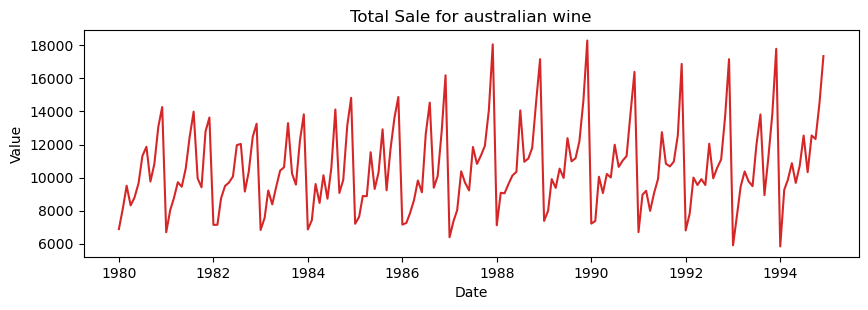

In [ ]:
plot_df(data, x=data.index, y=data.total_sales, title='Total Sale for australian wine') 

Let's obtain a boxplot for trend and seasonal components. We need some extra variables: year and month and to obtain them we are going to get a new version of the dataframe without the time index

In [ ]:
data_for_plot = data.copy()
data_for_plot.reset_index(inplace=True)
data_for_plot.head(1)

,Month,Fortified,Red,Rose,sparkling,Sweet white,Dry white,total_sales
0,1980-01-01,2585,464,112.0,1686,85,1954,6886.0


In [ ]:
data_for_plot['year'] = [d.year for d in data_for_plot.Month]
data_for_plot['month'] = [d.strftime('%b') for d in data_for_plot.Month]
data_for_plot.head(1)

,Month,Fortified,Red,Rose,sparkling,Sweet white,Dry white,total_sales,year,month
0,1980-01-01,2585,464,112.0,1686,85,1954,6886.0,1980,Jan


Obtain the plots and obtain some conclussions

* Trend: constant values until 1986, it looks to grow and decreases again from 1989 until 1992.
* Seasonality: two peaks (July and December)

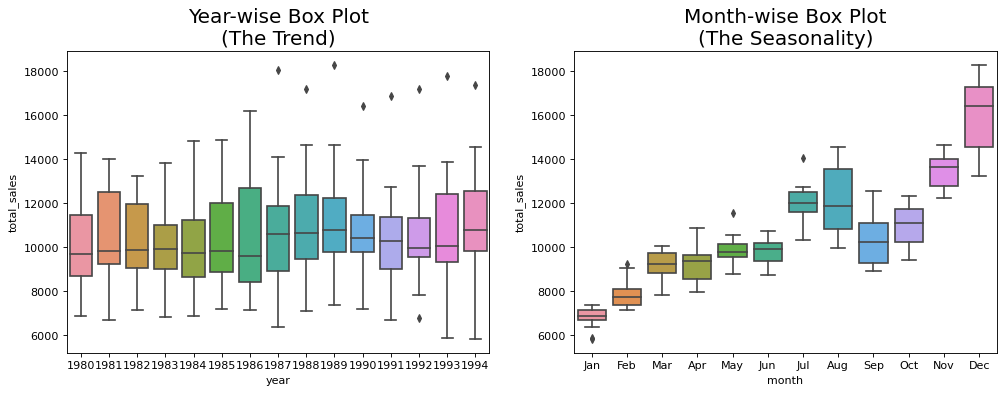

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), dpi= 80)
sns.boxplot(x='year', y='total_sales', data=data_for_plot, ax=axes[0])
sns.boxplot(x='month', y='total_sales', data=data_for_plot, ax=axes[1])

axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

3.- Does the ts follow an additive or a multiplicative model?

If we suppose an additive model...

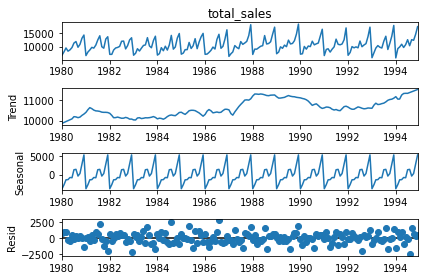

In [ ]:
data_add = seasonal_decompose(data['total_sales'], model='additive', extrapolate_trend='freq')
data_add.plot();

In [ ]:
data_add.resid.mean(), data_add.resid.std()

(15.555246373996688, 866.0381825616965)

If we suppose a multiplicative model...

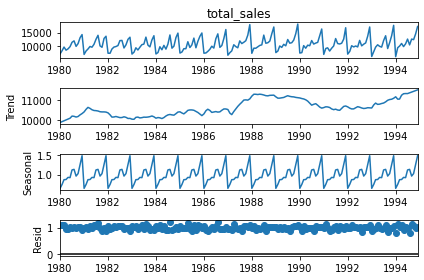

In [ ]:
data_mult = seasonal_decompose(data['total_sales'], model='multiplicative', extrapolate_trend='freq')
data_mult.plot();

In [ ]:
data_mult.resid.mean(), data_mult.resid.std()

(1.000873086157512, 0.07641262025489622)

Comparing both values, multiplicative model is choosen because the standard deviation is smaller and it is centered in 1

4.- If you decompose the ts, are the trend and seasonality similar to the ones of point 2?

In this point I was expecting some thoughts on how the trends and seasonal components obtained in exercise 3 are consistent with the observations in exercise 2.

Also, if a manual decomposition is obtained and compared to the results in exercise 2 is considered as a correct answer

5.- Is it stationary? If not, which steps did you apply to make it stationary?

Original serie

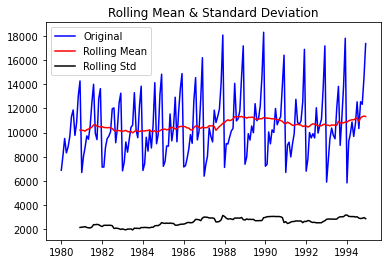

In [ ]:
test_stationarity(data['total_sales'], 12)

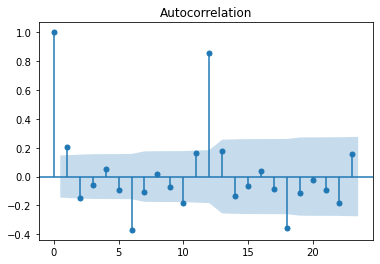

In [ ]:
plot_acf(data['total_sales']);

In [ ]:
interpret_dftest(adfuller(data.total_sales), 0.05)

ADF Statistic: -0.978858
p-value: 0.760897
Time series is not stationary
Critical Values:
	1%: -3.470
	5%: -2.879
	10%: -2.576


In [ ]:
interpret_kpsstest(kpss(data.total_sales), 0.05)

KPSS Statistic: 0.683167
p-value: 0.015076
Time series is stationary
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/Applications/anaconda3/envs/env_for_ts/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


Seasonal differencing (N=12)

In [ ]:
data['total_sales_seasonal_dif'] = data['total_sales'] - data['total_sales'].shift(12)
data.head(1)

,Fortified,Red,Rose,sparkling,Sweet white,Dry white,total_sales,total_sales_seasonal_dif
Month,,,,,,,,
1980-01-01,2585,464,112.0,1686,85,1954,6886.0,NaN


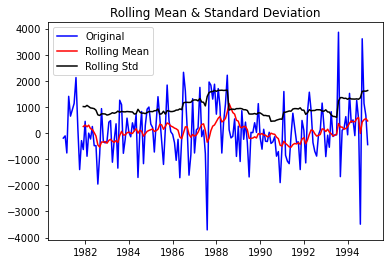

In [ ]:
test_stationarity(data['total_sales_seasonal_dif'].dropna(), 12)

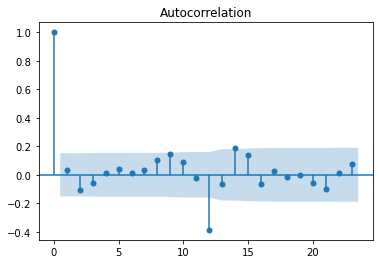

In [ ]:
plot_acf(data['total_sales_seasonal_dif'].dropna());

In [ ]:
interpret_dftest(adfuller(data.total_sales_seasonal_dif.dropna()), 0.05)

ADF Statistic: -3.608792
p-value: 0.005595
We can reject the null hypothesis. Time series is stationary
Critical Values:
	1%: -3.473
	5%: -2.880
	10%: -2.577


In [ ]:
interpret_kpsstest(kpss(data.total_sales_seasonal_dif.dropna()), 0.05)

KPSS Statistic: 0.082271
p-value: 0.100000
We can reject the null hypothesis. Time series is not stationary
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/Applications/anaconda3/envs/env_for_ts/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/Applications/anaconda3/envs/env_for_ts/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Normal differencing (N=1)

In [ ]:
data['total_sales_dif'] = data['total_sales'] - data['total_sales'].shift(1)

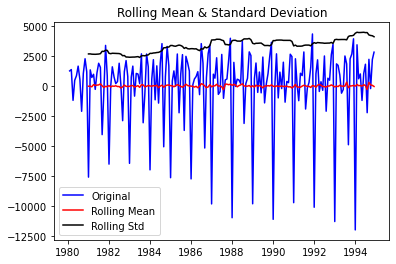

In [ ]:
test_stationarity(data['total_sales_dif'].dropna(), 12)

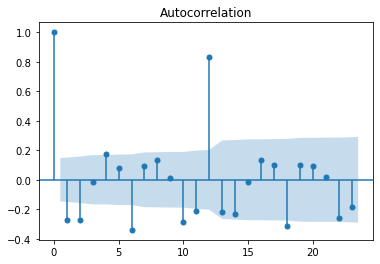

In [ ]:
plot_acf(data['total_sales_dif'].dropna());

In [ ]:
interpret_dftest(adfuller(data['total_sales_dif'].dropna()), 0.05)

ADF Statistic: -32.777276
p-value: 0.000000
We can reject the null hypothesis. Time series is stationary
Critical Values:
	1%: -3.470
	5%: -2.879
	10%: -2.576


In [ ]:
interpret_kpsstest(kpss(data['total_sales_dif'].dropna()), 0.05)

KPSS Statistic: 0.077109
p-value: 0.100000
We can reject the null hypothesis. Time series is not stationary
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/Applications/anaconda3/envs/env_for_ts/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/Applications/anaconda3/envs/env_for_ts/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Log and differencing

In [ ]:
data['total_sales_log_dif'] = np.log(data['total_sales']) - np.log(data['total_sales']).shift(1)

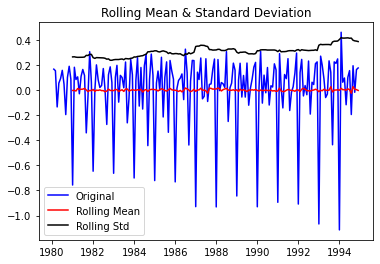

In [ ]:
test_stationarity(data['total_sales_log_dif'], 12)

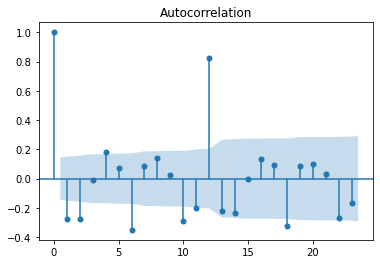

In [ ]:
plot_acf(data['total_sales_log_dif'].dropna());

In [ ]:
interpret_dftest(adfuller(data['total_sales_log_dif'].dropna()), 0.05)

ADF Statistic: -32.932569
p-value: 0.000000
We can reject the null hypothesis. Time series is stationary
Critical Values:
	1%: -3.470
	5%: -2.879
	10%: -2.576


In [ ]:
interpret_kpsstest(kpss(data['total_sales_log_dif'].dropna()), 0.05)

KPSS Statistic: 0.067859
p-value: 0.100000
We can reject the null hypothesis. Time series is not stationary
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/Applications/anaconda3/envs/env_for_ts/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/Applications/anaconda3/envs/env_for_ts/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


As a summary:

Please, take into account for rolling values the magnitude of the values. KPSS test always return that the transformed timeseries is not stationary, we will discard it to take a decision.

| Timeseries           | Rolling values                   | Correlogram                                 | ADF Test       | KPSS Test      |
| ---------------------|----------------------------------|---------------------------------------------|----------------|----------------|
| Original             | Some variations                  | Multiple lags over confident values         | Not stationary | Stationary     |
| Seasonal dif. (N=12) | Small variations                 | Values under confident values except lag=12 | Stationary     | Not Stationary |
| Normal dif. (N=1)    | Mean is zero but variance is not | Multiple lags over confident values         | Stationary     | Not Stationary |
| Log + diff (N=1)     | Mean is zero but variance is not | Multiple lags over confident values         | Stationary     | Not Stationary |

With the strong seasonality observed in the analysis of the timeseries the seasonal differencing is choosen

6.- Build a benchmark model to predict the next 6 periods. Choose an error measurement and obtain the error of the prediction?

Check last 7 records to obtain the required date to split data in train and test

In [ ]:
data.tail(7)

,Fortified,Red,Rose,sparkling,Sweet white,Dry white,total_sales,total_sales_seasonal_dif,total_sales_dif,total_sales_log_dif
Month,,,,,,,,,,
1994-06-01,2592,2660,45.0,1693,227,3517,10734.0,1250.0,1055.0,0.103458
1994-07-01,2714,3670,NaN,2031,225,3905,12545.0,564.0,1811.0,0.155906
1994-08-01,2294,2665,NaN,1495,205,3670,10329.0,-3489.0,-2216.0,-0.194367
1994-09-01,2416,2639,46.0,2968,259,4221,12549.0,3610.0,2220.0,0.194686
1994-10-01,2016,2226,51.0,3385,254,4404,12336.0,1137.0,-213.0,-0.017119
1994-11-01,2799,2586,63.0,3729,275,5086,14538.0,669.0,2202.0,0.164244
1994-12-01,2467,2684,84.0,5999,394,5725,17353.0,-442.0,2815.0,0.176999


Obtain train and test

In [ ]:
data_train = data[:'1994-06-01']
data_test = data['1994-07-01':]
data_train.shape, data_test.shape

((174, 10), (6, 10))

Due to the strong seasonality we choose Seasonal naive as a benchmark

* **Seasonal Naive: 0.28092**

In [ ]:
data_test['y_hat_seasonal_naive'] = data_train['total_sales'].iloc[-6:].values
forecast_accuracy(data_test['y_hat_seasonal_naive'], data_test['total_sales'])

/Applications/anaconda3/envs/env_for_ts/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


{'mape': 0.28092677951429845}

7.- Build an AR or a MA model. How does the error change?

First, let's obtain the potential orders for models AR and MA

In [ ]:
obtain_order_model(data_train['total_sales_seasonal_dif'].dropna())

NameError: ignored

In [ ]:
period_forecast = 6

AR

PACF suggests order 9  or 12

* AR(1): 0.99267
* AR(2): 0.99442
* AR(8): 0.98569
* **AR(9): 0.98090**
* AR(10): 0.98149
* AR(11): 0.98339
* AR(12): 0.99532
* AR(13): 0.99807

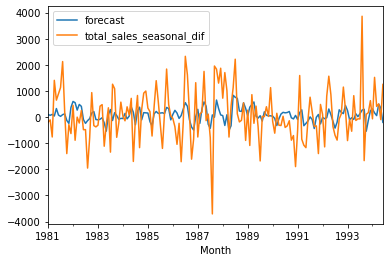

In [ ]:
model_ar = ARIMA(data_train['total_sales_seasonal_dif'].dropna(), order=(9, 0, 0))  
model_ar_fitted = model_ar.fit(disp=-1)
model_ar_fitted.plot_predict(dynamic=False);

In [ ]:
forecast, se, confidence = model_ar_fitted.forecast(period_forecast, alpha=0.05)
data_test['y_hat_ar'] = forecast
forecast_accuracy(data_test['y_hat_ar'], data_test['total_sales'])

/Applications/anaconda3/envs/env_for_ts/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


{'mape': 0.9809081848353639}

MA

ACF suggests order = 12

* MA(8): 0.98527
* **MA(9): 0.98119**
* MA(10): 0.98127
* MA(11): 0.98553
* MA(12): 1.00228

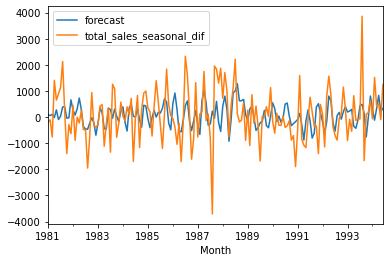

In [ ]:
model_ma = ARIMA(data_train['total_sales_seasonal_dif'].dropna(), order=(0, 0, 9))  
model_ma_fitted = model_ma.fit(disp=-1)
model_ma_fitted.plot_predict(dynamic=False);

In [ ]:
forecast, se, confidence = model_ma_fitted.forecast(period_forecast, alpha=0.05)
data_test['y_hat_ma'] = forecast
forecast_accuracy(data_test['y_hat_ma'], data_test['total_sales'])

/Applications/anaconda3/envs/env_for_ts/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


{'mape': 0.9811905107272225}

ARMA

The combination of high orders for both models normally produce an error because it does not converge o there is a zero problem in someplace

* ARMA(1, 0, 1): 0.99293
* ARMA(2, 0, 1): 0.99555
* ARMA(3, 0, 1): 0.99498
* ARMA(1, 0, 2): 0.99539
* ARMA(1, 0, 3): 0.99502
* ARMA(1, 0, 4): 0.98519
* **ARMA(1, 0, 5): 0.98211**
* ARMA(2, 0, 5): 0.99312
* ARMA(9, 0, 9): 0.9836

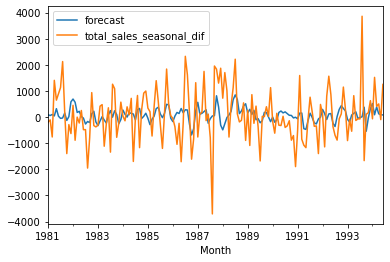

In [ ]:
model_arma = ARIMA(data_train['total_sales_seasonal_dif'].dropna(), order=(1, 0, 5))  
model_arma_fitted = model_arma.fit(disp=-1)
model_arma_fitted.plot_predict(dynamic=False);

In [ ]:
forecast, se, confidence = model_arma_fitted.forecast(period_forecast, alpha=0.05)
data_test['y_hat_arma'] = forecast
forecast_accuracy(data_test['y_hat_arma'], data_test['total_sales'])

/Applications/anaconda3/envs/env_for_ts/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


{'mape': 0.9821131874502868}

8.- Build an ARIMA or SARIMA model. How does it affect to the error?

ARIMA

* ARIMA(1, 1, 1): 0.16837
* ARIMA(2, 1, 1): 0.16756
* ARIMA(3, 1, 1): 0.16773
* ARIMA(1, 1, 2): 0.16314
* **ARIMA(2, 1, 2): 0.14526**
* ARIMA(2, 1, 3): MAPE = 0.18033

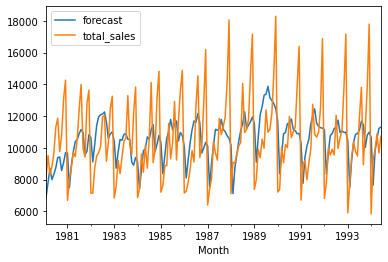

In [ ]:
model_arima = ARIMA(data_train['total_sales'].dropna(), order=(2, 1, 2))  
model_arima_fitted = model_arima.fit(disp=-1)
model_arima_fitted.plot_predict(dynamic=False);

In [ ]:
forecast, se, confidence = model_arima_fitted.forecast(period_forecast, alpha=0.05)
data_test['y_hat_arima'] = forecast
forecast_accuracy(data_test['y_hat_arima'], data_test['total_sales'])

/Applications/anaconda3/envs/env_for_ts/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


{'mape': 0.14526260205667518}

SARIMA model

* ARIMA(1, 1, 1) (1, 1, 1, 12): 0.09877
* ARIMA(2, 1, 1) (1, 1, 1, 12): 0.09866
* ARIMA(3, 1, 1) (1, 1, 1, 12): 0.10118
* ARIMA(2, 1, 2) (1, 1, 1, 12): 0.10380
* **ARIMA(2, 1, 1) (2, 1, 1, 12): 0.09503**
* ARIMA(2, 1, 1) (3, 1, 1, 12): 0.09936
* ARIMA(2, 1, 1) (2, 1, 2, 12): 0.09746


In [ ]:
model_sarima = SARIMAX(data_train['total_sales'].dropna(), order=(2, 1, 1), seasonal_order=(2, 1, 1, 12))
model_sarima_fit = model_sarima.fit()

/Applications/anaconda3/envs/env_for_ts/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
forecast = model_sarima_fit.forecast(steps=6)
data_test['y_hat_sarima'] = forecast
forecast_accuracy(data_test.y_hat_sarima, data_test.total_sales)

/Applications/anaconda3/envs/env_for_ts/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


{'mape': 0.09503331805556196}

9.- If you use auto_arima functionality, does the new model have the same parameters? How does it affect to the error?

Autoarima witouth seasonality

* **Autoarima: ARIMA(2,0,0)(0,0,0)[0]: 0.18940**

In [ ]:
model_autoarima = pm.auto_arima(data_train.total_sales, 
                                start_p=1, start_q=1, # initial values of p and q
                                test='adf',       # use adftest to find optimal 'd'
                                max_p=10, max_q=10, # maximum p and q
                                m=1,              # frequency of series, 1 means no seasonal data
                                d=None,           # let model determine 'd'
                                seasonal=False,   # No Seasonality
                                start_P=0,
                                D=0,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3729.251, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3307.842, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3563.354, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=3297.569, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=3272.807, Time=0.06 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=3231.108, Time=0.14 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=3258.898, Time=0.12 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=3232.606, Time=0.25 sec
 A

In [ ]:
forecast, confidence = model_autoarima.predict(n_periods=period_forecast, return_conf_int=True)
data_test['y_hat_autoarima'] = forecast
forecast_accuracy(data_test['y_hat_autoarima'], data_test['total_sales'])

/Applications/anaconda3/envs/env_for_ts/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


{'mape': 0.18940319501865344}

**Autoarima with seasonality**

It takes longer to fit
* **Autoarima:  ARIMA(0,0,0)(0,5,0)[12]: 0.35521**

In [ ]:
model_y_hat_autoarima_seasonality = pm.auto_arima(data_train.total_sales,
                                                  start_p=1, start_q=1, # initial values of p and q
                                                  test='adf',           # use adftest to find optimal 'd'
                                                  max_p=5, max_q=5,     # maximum p and q (adjusted)
                                                  m=12,                 # month wise series
                                                  d=None,               # let model determine 'd'
                                                  seasonal=True,        # For seasonal arima
                                                  start_P=0,
                                                  D=5,                  # For seasonal arima
                                                  trace=True,
                                                  error_action='ignore',
                                                  suppress_warnings=True,
                                                  stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,5,1)[12]             : AIC=2248.815, Time=58.58 sec
 ARIMA(0,0,0)(0,5,0)[12]             : AIC=2186.337, Time=2.91 sec
 ARIMA(1,0,0)(1,5,0)[12]             : AIC=inf, Time=23.47 sec
 ARIMA(0,0,1)(0,5,1)[12]             : AIC=inf, Time=14.06 sec
 ARIMA(0,0,0)(1,5,0)[12]             : AIC=inf, Time=9.58 sec
 ARIMA(0,0,0)(0,5,1)[12]             : AIC=inf, Time=8.51 sec
 ARIMA(0,0,0)(1,5,1)[12]             : AIC=inf, Time=11.29 sec
 ARIMA(1,0,0)(0,5,0)[12]             : AIC=inf, Time=5.49 sec
 ARIMA(0,0,1)(0,5,0)[12]             : AIC=inf, Time=5.59 sec
 ARIMA(1,0,1)(0,5,0)[12]             : AIC=2246.177, Time=12.46 sec
 ARIMA(0,0,0)(0,5,0)[12] intercept   : AIC=2181.784, Time=5.39 sec
 ARIMA(0,0,0)(1,5,0)[12] intercept   : AIC=inf, Time=25.57 sec
 ARIMA(0,0,0)(0,5,1)[12] intercept   : AIC=inf, Time=14.03 sec
 ARIMA(0,0,0)(1,5,1)[12] intercept   : AIC=2620.988, Time=30.01 sec
 ARIMA(1,0,0)(0,5,0)[12] intercept   : AIC=inf, Time=9.3

In [ ]:
forecast, confidence = model_y_hat_autoarima_seasonality.predict(n_periods=6, return_conf_int=True)
data_test['y_hat_autoarima_seasonality'] = pd.Series(forecast, index=data_test.index)
forecast_accuracy(data_test.y_hat_autoarima_seasonality, data_test.total_sales)

/Applications/anaconda3/envs/env_for_ts/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


{'mape': 0.3552127045028093}

10.- If you build a model with Prophet, does the error increase or decrease?

Prophet

* Prophet with seasonality: 0.09957

Load data and create global variable named y according to Prophet requeriments

In [ ]:
data_for_prophet = pd.read_csv(path, sep=',')
data_for_prophet['y'] = data_for_prophet[['Fortified', 'Red', 'Rose', 'sparkling', 'Sweet white', 'Dry white']].sum(axis=1)
data_for_prophet.head(1)

,Month,Fortified,Red,Rose,sparkling,Sweet white,Dry white,y
0,Jan-80,2585,464,112.0,1686,85,1954,6886.0


Change format of the date variable

In [ ]:
data_for_prophet['Month'] = pd.DatetimeIndex(data_for_prophet['Month'])
data_for_prophet.head(1)

,Month,Fortified,Red,Rose,sparkling,Sweet white,Dry white,y
0,1980-01-01,2585,464,112.0,1686,85,1954,6886.0


Change column names

In [ ]:
data_for_prophet = data_for_prophet.rename(columns={'Month': 'ds'})

In [ ]:
model_prophet = Prophet(
    interval_width = 0.95,         # confidence interval
    yearly_seasonality = True,
    weekly_seasonality = False,
    daily_seasonality = False,
    holidays = None,               # include holidays or event date
)

In [ ]:
model_prophet.fit(data_for_prophet[:-6])

In [ ]:
future_dates = model_prophet.make_future_dataframe(periods=6, freq='MS')

In [ ]:
forecast = model_prophet.predict(future_dates)
forecast.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1980-01-01,10227.573955,4742.008086,8010.704690,10227.573955,10227.573955,-3826.861792,-3826.861792,-3826.861792,-3826.861792,-3826.861792,-3826.861792,0.0,0.0,0.0,6400.712163
1,1980-02-01,10233.630258,5954.436232,9401.969069,10233.630258,10233.630258,-2583.639657,-2583.639657,-2583.639657,-2583.639657,-2583.639657,-2583.639657,0.0,0.0,0.0,7649.990601
2,1980-03-01,10239.295832,7242.610930,10521.071420,10239.295832,10239.295832,-1343.313574,-1343.313574,-1343.313574,-1343.313574,-1343.313574,-1343.313574,0.0,0.0,0.0,8895.982259


In [ ]:
forecast.tail(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
177,1994-10-01,11107.762833,9515.041798,12958.933105,11107.204072,11108.313077,153.233228,153.233228,153.233228,153.233228,153.233228,153.233228,0.0,0.0,0.0,11260.996061
178,1994-11-01,11111.335741,11971.777333,15440.604508,11110.465083,11112.180470,2607.972557,2607.972557,2607.972557,2607.972557,2607.972557,2607.972557,0.0,0.0,0.0,13719.308298
179,1994-12-01,11114.793395,14646.486227,18032.803212,11113.727855,11115.966237,5187.461146,5187.461146,5187.461146,5187.461146,5187.461146,5187.461146,0.0,0.0,0.0,16302.254541


In [ ]:
data_test['y_hat_prophet'] = forecast['yhat'][-6:].values
data_test.head(6)

/Applications/anaconda3/envs/env_for_ts/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Fortified,Red,Rose,sparkling,Sweet white,Dry white,total_sales,total_sales_seasonal_dif,total_sales_dif,total_sales_log_dif,y_hat_seasonal_naive,y_hat_ar,y_hat_ma,y_hat_arma,y_hat_arima,y_hat_sarima,y_hat_autoarima,y_hat_autoarima_seasonality,y_hat_prophet
Month,,,,,,,,,,,,,,,,,,,
1994-07-01,2714,3670,NaN,2031,225,3905,12545.0,564.0,1811.0,0.155906,5837.0,236.810033,527.044481,378.899003,11922.378854,12591.814427,10787.987267,10787.987267,12317.824056
1994-08-01,2294,2665,NaN,1495,205,3670,10329.0,-3489.0,-2216.0,-0.194367,9264.0,203.839892,-272.431447,138.033074,12207.043726,12848.523451,10565.448378,10565.448378,12578.165017
1994-09-01,2416,2639,46.0,2968,259,4221,12549.0,3610.0,2220.0,0.194686,9869.0,113.966809,-104.429428,130.929529,12038.975676,10000.181606,10504.560494,10504.560494,10571.187075
1994-10-01,2016,2226,51.0,3385,254,4404,12336.0,1137.0,-213.0,-0.017119,10874.0,286.900465,768.594022,209.369303,11750.439917,11592.983253,10540.626851,10540.626851,11260.996061
1994-11-01,2799,2586,63.0,3729,275,5086,14538.0,669.0,2202.0,0.164244,9679.0,393.357515,553.477914,321.136896,11514.577197,14159.025270,10562.078908,10562.078908,13719.308298
1994-12-01,2467,2684,84.0,5999,394,5725,17353.0,-442.0,2815.0,0.176999,10734.0,287.074434,89.639834,247.434303,11382.785929,17927.945021,10558.778806,10558.778806,16302.254541


In [ ]:
forecast_accuracy(data_test['y_hat_prophet'], data_test['total_sales'])

{'mape': 0.09957955442886159}

# Summary

If we collect the best solution for each case:
* Seasonal Naive: 0.28092
* AR(9): 0.98090
* MA(9): 0.98119
* ARMA(1, 0, 5): 0.98211
* ARIMA(2, 1, 2): 0.14526
* **ARIMA(2, 1, 1) (2, 1, 1, 12): 0.09503**
* ARIMA(2,0,0)(0,0,0)[0]: 0.18940 (autoarima)
* ARIMA(0,0,0)(0,5,0)[12]: 0.35521 (autoarima)
* Prophet with seasonality: 0.09957